<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jihoyeo/mobility-simulation-book/blob/main/ko/chapter2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>
<br>

## 2.4 Road Network and Geometry

### 2.4.1 Open Street Map 데이터 살펴보기

[오픈스트리트맵 한국](https://osm.kr/usage/)에서는 대한민국의 OSM을 이용하는 상세한 방법에 대한 메뉴얼을 제공해주고 있다. 상세한 내용은 이곳을 참고하면 되며, 본 장에서는 한국의 OSM 데이터를 불러와서 `OSMnx` 패키지로 간략히 분석하고 시각화 하는 작업을 진행한다. 

- OSM을 이용해서 수도권 지역의 도로 데이터를 가져오고, 시각화 하는 작업을 수행한다  
- OSMnx 이용해서 그래프 분석하고, 복잡한 그래프를 간소화 하는 작업을 실습한다

#### [1] Open Street Map 데이터 취득하기 (.osm.pbf 파일)
- 사이트 : https://download.geofabrik.de/asia.html
- South Korea 부분의 .osm.pbf 버튼 클릭
- 여기서 다운로드 받은 .osm.pbf 파일은 본 챕터에서는 사용하지 않지만 향후 Vehicle Router를 만들 때 활용한다. 

In [4]:
import networkx as nx
import osmnx as ox
import folium

ox.config(use_cache=True, log_console=True)
ox.__version__

C:\Users\jiho\AppData\Local\Temp\ipykernel_55604\4097976119.py:5: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)


'1.9.4'

#### [2] 내가 원하는 지역 osm 지도를 그래프 형태로 표현
- 본 실습에서는 `OSMnx` 패키지를 사용하여 원하는 도시의 Graph를 Python으로 가져와서 분석하는 실습을 진행한다.

In [9]:
# get a graph for some city
# www.openstreetmap.org에서 검색 결과가 city-state-country 단위로 나와야 함 

# # 서울특별시 전체 도로 네트워크 불러오기
# G = ox.graph_from_place('서울특별시, 대한민국', network_type='drive')

# osmnx 그래프 생성( osm 지도 다운로드 )
G = ox.graph_from_place('성남시, 대한민국', network_type='drive')

`network_type='drive'`는 도로 네트워크(차량이 다닐 수 있는 도로)만을 가져오는 옵션이다. 따라서 보행자 도로, 자전거 도로, 또는 작은 골목 등은 포함되지 않을 수 있다. 전체적인 도로와 교통 네트워크를 모두 포함하려면 다른 network_type을 사용할 수 있다.

OSMnx에서 제공하는 네트워크 타입 옵션들은 다음과 같다.

- 'all': 모든 도로 네트워크를 가져온다 (자동차, 자전거, 보행자 도로 등 포함)
- 'all_private': 모든 도로 네트워크(사유지 도로 포함)
- 'bike': 자전거 네트워크만 가져온다
- 'walk': 보행자 네트워크만 가져온다
- 'drive': 차량이 다니는 도로만 가져온다
- 'drive_service': 서비스 도로(차량 진입 가능하지만 주요 도로는 아님)도 포함

전체 네트워크를 가져오려면 다음과 같이 사용할 수 있다. 

```python
G = ox.graph_from_place('성남시, 경기도, 대한민국', network_type='all')
```

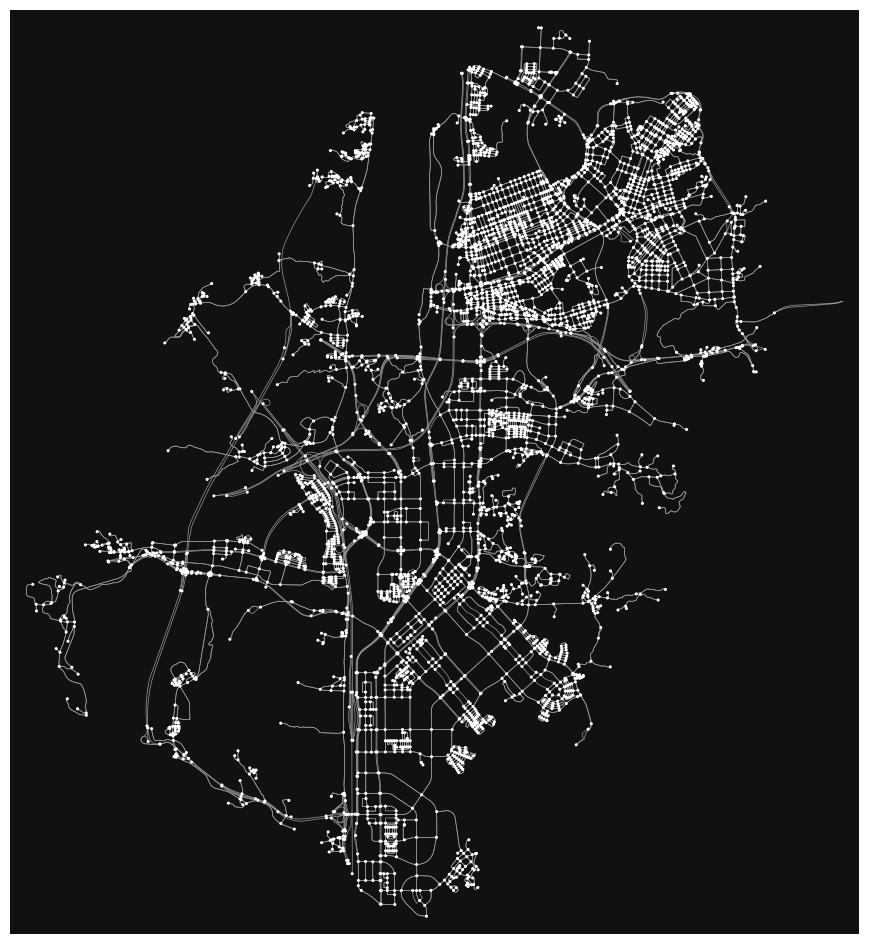

In [10]:
## 간단한 시각화
# fig, ax = ox.plot_graph(G)
fig, ax = ox.plot_graph(
                            G, 
                            figsize=(12, 12),
                            node_size=5, 
                            edge_linewidth=0.5
                        )

- 하지만 위와 같이 시각화를 한다면, static map이기 때문에 원하는 특정 지역을 세밀하게 관찰하기가 어렵다.  
- Interactive Map을 사용하면 속도는 더 느리지만, 보다 상세히 그래프를 살펴볼 수 있다. 

In [11]:
# 그래프의 중심점 계산
center_lat, center_lon = ox.geocode('성남시, 대한민국')

# folium 맵 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodbpositron')

# 엣지(도로) 추가
for u, v, data in G.edges(data=True):
    locations = [(G.nodes[u]['y'], G.nodes[u]['x']), (G.nodes[v]['y'], G.nodes[v]['x'])]
    
    # 엣지(street) 정보 생성
    edge_info = f"도로명: {data.get('name', 'Unknown')}<br>" \
                f"길이: {data.get('length', 0):.2f} m<br>" \
                f"도로 유형: {data.get('highway', 'Unknown')}"
    
    folium.PolyLine(
        locations=locations,
        weight=2,
        color='blue',
        opacity=0.7,
        tooltip=edge_info
    ).add_to(m)

# 노드(교차점) 추가
for node, data in G.nodes(data=True):
    # 노드에 연결된 엣지 수 계산
    degree = G.degree(node)
    
    # 노드 정보 생성
    node_info = f"Node ID: {node}<br>" \
                f"위도: {data['y']:.6f}<br>" \
                f"경도: {data['x']:.6f}<br>" \
                f"연결된 도로 수: {degree}"
    
    folium.CircleMarker(
        location=(data['y'], data['x']),
        radius=3,
        popup=node_info,
        color='red',
        fill=True,
        fillColor='red',
        tooltip=f"Node ID: {node}"
    ).add_to(m)

# 맵 저장
m.save("../data/Sungnam_road_network_vis.html")

- 한가지 이상한 점이 있다. 모든 Egde가 직선으로표현되어, 실제 Basemap에 있는 도로와 정확하게 매칭되지 않는다
- Open Steet Map의 edge는 도로의 geometry 정보를 포함하고 있으며, 이 정보를 사용하면 실제도로와 유사하게 시각화가 가능하다

In [12]:
# folium 맵 생성 (CARTODB positron 베이스맵 사용)
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodbpositron')

# 엣지(도로) 추가
for u, v, data in G.edges(data=True):
    if 'geometry' in data:
        # 실제 도로 지오메트리 사용
        geometry = data['geometry']
        coordinates = list(geometry.coords)
        locations = [(y, x) for x, y in coordinates]
    else:
        # 지오메트리 정보가 없는 경우 직선으로 표시
        locations = [(G.nodes[u]['y'], G.nodes[u]['x']), (G.nodes[v]['y'], G.nodes[v]['x'])]
    
    # 엣지(street) 정보 생성
    edge_info = f"도로명: {data.get('name', 'Unknown')}<br>" \
                f"길이: {data.get('length', 0):.2f} m<br>" \
                f"도로 유형: {data.get('highway', 'Unknown')}"
    
    folium.PolyLine(
        locations=locations,
        weight=2,
        color='blue',
        opacity=0.7,
        tooltip=edge_info
    ).add_to(m)

# 노드(교차점) 추가
for node, data in G.nodes(data=True):
    # 노드에 연결된 엣지 수 계산
    degree = G.degree(node)
    
    # 노드 정보 생성
    node_info = f"Node ID: {node}<br>" \
                f"위도: {data['y']:.6f}<br>" \
                f"경도: {data['x']:.6f}<br>" \
                f"연결된 도로 수: {degree}"
    
    folium.CircleMarker(
        location=(data['y'], data['x']),
        radius=3,
        popup=node_info,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.7,
        tooltip=f"Node ID: {node}"
    ).add_to(m)

# 맵 저장
m.save("../data/Sungnam_road_network_vis_with_geometry.html")

위 HTML 파일을 열어서 한번 살펴보자. `Folium`은 Leaflet.js 기반으로 HTML을 생성하고 이를 웹페이지로 렌더링한다.  
지도를 그리거나 데이터를 시각화할 때 매번 HTML 파일을 업데이트하거나 렌더링해야 하기 때문에 시간이 더 소요될 수 있다.

데이터가 매우 크고, 수가 많을 경우 GPU 가속을 활용하는 시각화 패키지나 툴을 이용하는 것이 도움이 된다.  
베이스 맵의 경우 https://www.mapbox.com/에서 직접 커스터마이즈 하면 된다.

In [14]:
import pydeck as pdk
import pandas as pd

# 엣지(도로) 데이터 생성
edges = []
for u, v, data in G.edges(data=True):
    if 'geometry' in data:
        geometry = data['geometry']
        coordinates = list(geometry.coords)
        locations = [(y, x) for x, y in coordinates]
    else:
        locations = [(G.nodes[u]['y'], G.nodes[u]['x']), (G.nodes[v]['y'], G.nodes[v]['x'])]
    
    for i in range(len(locations) - 1):
        edges.append({
            'start_lat': locations[i][0],
            'start_lon': locations[i][1],
            'end_lat': locations[i+1][0],
            'end_lon': locations[i+1][1],
            'name': data.get('name', 'Unknown'),
            'length': data.get('length', 0),
            'highway': data.get('highway', 'Unknown')
        })

edges_df = pd.DataFrame(edges)

# 노드(교차점) 데이터 생성
nodes = []
for node, data in G.nodes(data=True):
    nodes.append({
        'lat': data['y'],
        'lon': data['x'],
        'node_id': node,
        'degree': G.degree(node)
    })

nodes_df = pd.DataFrame(nodes)

# Pydeck의 LineLayer와 ScatterplotLayer 설정
edge_layer = pdk.Layer(
    "LineLayer",
    data=edges_df,
    get_source_position='[start_lon, start_lat]',
    get_target_position='[end_lon, end_lat]',
    get_color=[0, 0, 255],
    get_width=2,
    pickable=True,
    auto_highlight=True,
    tooltip={
        "html": "도로명: {name}<br>길이: {length} m<br>도로 유형: {highway}",
        "style": {"color": "white"}
    }
)

node_layer = pdk.Layer(
    "ScatterplotLayer",
    data=nodes_df,
    get_position='[lon, lat]',
    get_fill_color=[255, 0, 0],
    get_radius=20,
    pickable=True,
    auto_highlight=True,
    tooltip={
        "html": "Node ID: {node_id}<br>연결된 도로 수: {degree}",
        "style": {"color": "white"}
    }
)

# Pydeck View 설정
view_state = pdk.ViewState(
    latitude=center_lat,
    longitude=center_lon,
    zoom=12,
    bearing=0,
    pitch=0
)

# Pydeck 맵 렌더링
r = pdk.Deck(
    layers=[edge_layer, node_layer],
    initial_view_state=view_state
)

# 맵 저장 (출력 없이)
r.to_html("../data/Sungnam_road_network_vis_with_pydeck.html")
print("Pydeck 맵이 저장되었습니다.")

Pydeck 맵이 저장되었습니다.


#### [3] 여러 네트워크를 한번에 표시

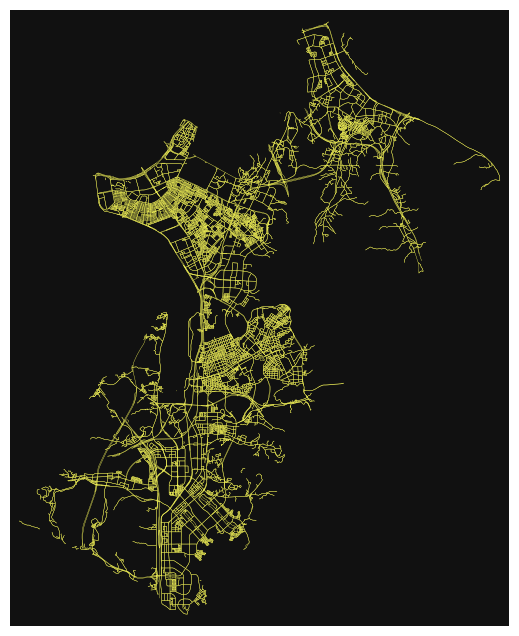

In [20]:
# 여러 위치에서 네트워크를 생성하기 위한 서울 지역 리스트 설정
places = [
    '성남시, 대한민국',  
    '송파구, 서울특별시, 대한민국',  
    '하남시, 대한민국',  
]

# retain_all=True를 사용하여 모든 연결되지 않은 서브그래프도 유지 (연속된 네트워크가 아닌 경우에도 유지)
# 여러 장소를 기반으로 차량 도로 네트워크(network_type="drive")를 생성
G = ox.graph_from_place(places, network_type="drive", retain_all=True)

# 생성된 네트워크 시각화 
fig, ax = ox.plot_graph(
    G,                      
    node_size=0,           
    edge_color="#FFFF5C",    
    edge_linewidth=0.25      
)

#### [4]  기초적인 도로네트워크 속성 파악 및 시각화

In [21]:
# osmnx 그래프 생성( osm 지도 다운로드 )
G = ox.graph_from_place('성남시, 대한민국', network_type='drive')

In [22]:
# 기본 그래프 정보 출력
print("노드 수:", len(G.nodes))
print("엣지 수:", len(G.edges))

노드 수: 4908
엣지 수: 13233


`OSMnx` 패키지에 있는 `basic_stats`라는 함수를 사용하면 기본적인 네트워크 통계를 출력해준다. 아래와 같은 정보들이 포함된다. 

- **n: 그래프의 총 노드 수**
- **m: 그래프의 총 엣지 수**
- **k_avg: 평균 노드 차수 (한 노드에 연결된 평균 엣지 수)**
- **edge_length_total: 모든 엣지 길이의 총합 (미터 단위)**
- edge_length_avg: 평균 엣지 길이 (미터 단위)
- **streets_per_node_avg: 노드당 평균 Street 수**
- streets_per_node_counts: 각 Street수별 노드 개수 (예: 3개의 거리가 만나는 교차로의 수)
- streets_per_node_proportions: 각 Street 수별 노드 비율
- **intersection_count: 교차로의 총 개수**
- **street_length_total: 모든 거리의 총 길이 (미터 단위)**
- **street_segment_count: 거리 세그먼트의 총 개수**
- street_length_avg: 평균 Street 길이 (미터 단위)
- circuity_avg: 평균 우회도 (직선 거리 대비 실제 거리의 비율)
- self_loop_proportion: 자기 루프(같은 노드로 시작하고 끝나는 엣지)의 비율

In [23]:
# 기본 네트워크 통계 계산 및 출력
stats = ox.basic_stats(G)
print("\n기본 네트워크 통계:")
for key, value in stats.items():
    print(f"{key}: {value}")


기본 네트워크 통계:
n: 4908
m: 13233
k_avg: 5.39242053789731
edge_length_total: 1622659.8079999986
edge_length_avg: 122.62221778886108
streets_per_node_avg: 3.0554197229013855
streets_per_node_counts: {0: 0, 1: 441, 2: 24, 3: 3294, 4: 1121, 5: 27, 6: 1}
streets_per_node_proportions: {0: 0.0, 1: 0.08985330073349633, 2: 0.004889975550122249, 3: 0.6711491442542787, 4: 0.22840260798696008, 5: 0.005501222493887531, 6: 0.00020374898125509371}
intersection_count: 4467
street_length_total: 997178.0209999979
street_segment_count: 7465
street_length_avg: 133.58044487608814
circuity_avg: 1.0659417177433692
self_loop_proportion: 0.0021433355659745477


보다 세부적으로 Node와 Edge들이 어떤 속성을 가지고 있는지 알아보자.  
기본적으로 Graph의 Node와 Edge는 ~~~ 형태의 데이터 포맷을 가지고 있다. Python에서 보다 쉽게 이를 보기 위해서 Dataframe으로 변환하면 좋다. 

Node의 속성:
- Node ID: 노드의 고유 식별자 (일반적으로 OSM의 ID)
- x, y 좌표: 노드의 경도(longitude, x)와 위도(latitude, y)
- 기타 속성: 노드가 속한 구역의 정보 등 다양한 부가 정보가 포함될 수 있습니다.



In [24]:
# 처음 20개의 노드만 선택
sample_nodes = list(G.nodes(data=True))[:20]

# 각 노드의 특성을 딕셔너리 리스트로 변환
node_data = []
for node, data in sample_nodes:
    node_info = {'node_id': node}  # 노드의 고유 ID 추가
    node_info.update(data)  # 노드의 기타 속성 추가 (x, y 좌표 등)
    node_data.append(node_info)

# DataFrame으로 변환
node_df = pd.DataFrame(node_data)
node_df

,node_id,y,x,street_count,highway
0,414689872,37.462244,127.155179,4,NaN
1,414689878,37.422383,127.102033,4,traffic_signals
2,414689917,37.440888,127.131794,4,NaN
3,414689923,37.409577,127.124802,4,NaN
4,414689924,37.405432,127.123595,4,NaN
5,414689925,37.405433,127.125451,4,NaN
6,414689927,37.399175,127.125408,4,NaN
7,414689930,37.409160,127.123032,4,NaN
8,414689935,37.413087,127.120808,4,NaN
9,414689936,37.413800,127.122542,4,NaN


In [25]:
# 모든 node의 데이터를 가져옴
nodes = list(G.nodes(data=True))

# node에서 highway 속성만을 추출하여 리스트 생성
highway_types = []
for node_id, data in nodes:
    if 'highway' in data:
        highway_types.append(data['highway'])  # highway 속성이 있으면 리스트에 추가

# highway 타입별 개수 세기
highway_counts = pd.Series(highway_types).value_counts()
highway_counts

traffic_signals      146
motorway_junction     20
crossing               8
turning_circle         7
mini_roundabout        2
proposed               1
Name: count, dtype: int64

Edge의 속성:
- start_node, end_node: edge가 연결하는 두 노드의 ID
- length: edge의 길이 (단위는 보통 미터)
- highway type: 도로 유형 (예: residential, primary 등)
- geometry: 도로의 곡선 정보 (라인스트링 형태로 저장)
- oneway: 도로가 일방통행인지 여부

In [26]:
# 처음 5개의 엣지만 선택
sample_edges = list(G.edges(data=True))[:20]

# 각 엣지의 특성을 딕셔너리 리스트로 변환
edge_data = []
for u, v, data in sample_edges:
    edge_info = {'start_node': u, 'end_node': v}
    edge_info.update(data)
    edge_data.append(edge_info)

# DataFrame으로 변환
df = pd.DataFrame(edge_data)
df

,start_node,end_node,osmid,oneway,highway,reversed,length,ref,name,geometry,lanes,bridge
0,414689872,10712317417,1151530545,True,secondary_link,False,10.895,NaN,NaN,NaN,NaN,NaN
1,414689872,4809139436,54607084,False,secondary,False,36.738,342,남한산성로,"LINESTRING (127.1551794 37.4622445, 127.155167...",NaN,NaN
2,414689872,2684209530,220199776,True,secondary,False,53.796,342,수정로,"LINESTRING (127.1551794 37.4622445, 127.155156...",NaN,NaN
3,414689878,4299327239,829530778,False,secondary,False,58.502,23,대왕판교로,NaN,8,NaN
4,414689878,1668416833,829530778,False,secondary,True,15.431,23,대왕판교로,NaN,8,NaN
5,414689878,4299327232,70986684,True,trunk_link,False,67.538,NaN,NaN,"LINESTRING (127.102033 37.4223826, 127.1019343...",NaN,NaN
6,414689917,6293360179,60609785,True,tertiary,False,49.945,NaN,제일로,NaN,NaN,NaN
7,414689917,759684094,218842461,True,tertiary,False,2.893,NaN,수정로,NaN,NaN,NaN
8,414689923,2939333063,186410776,False,tertiary,True,204.641,NaN,양현로,"LINESTRING (127.1248017 37.4095773, 127.124729...",4,NaN
9,414689923,1970949890,522869003,False,tertiary,False,58.064,NaN,양현로,"LINESTRING (127.1248017 37.4095773, 127.124879...",4,NaN


OSM에서 도로 타입이 총 몇가지로 구분이 되는지 알아보려면 아래와 같이 할 수 있다.  
매우 많은 도로유형이 있는 것을 알 수 있다. 각각의 상세한 설명 및 기준이 궁금하면 다음을 참고하자. https://wiki.openstreetmap.org/wiki/Key:highway

In [28]:
# 모든 edge의 데이터를 가져옴
edges = list(G.edges(data=True))

# highway 속성만을 추출하여 리스트 생성
highway_types = []
for u, v, data in edges:
    if 'highway' in data:
        # 일부 엣지의 highway 속성이 리스트일 수 있어 처리
        if isinstance(data['highway'], list):
            highway_types.extend(data['highway'])
        else:
            highway_types.append(data['highway'])

# highway 타입별 개수 세기
highway_counts = pd.Series(highway_types).value_counts()
highway_counts

residential       8357
tertiary          2605
unclassified       747
primary            356
secondary          300
living_street      236
tertiary_link      196
primary_link       120
trunk_link         113
motorway_link       88
secondary_link      63
trunk               56
motorway            38
road                12
busway               1
Name: count, dtype: int64

### 2.4.2 최단거리 분석

- 두 지점까지의 거리를 추출하는 것은 교통 데이터를 분석할 때 매우 빈번히 쓰인다
- 가장 간단한 것은 직선거리를 추출하는 것이지만, 실제 도로위를 움직이는 차량이나 사람의 움직임과는 큰 차이를 보인다.

#### [1] 두 지점간 Network Distance 구하기 실습

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium

%matplotlib inline

In [ ]:
# pip install scikit-learn
# pip install folium
# pip install scipy

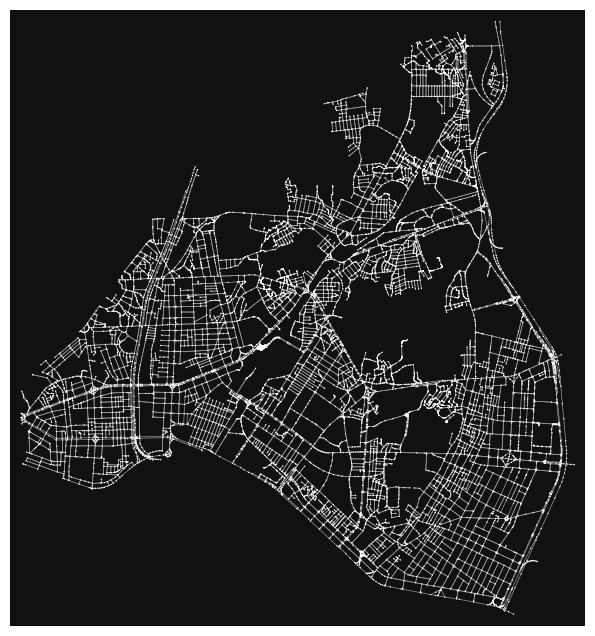

In [30]:
# 원하는 지역 그래프 생성
G = ox.graph_from_place('동대문구, 서울, 대한민국', network_type='drive', simplify=False)

# 그래프 시각화
fig, ax = ox.plot_graph(
                            G, 
                            figsize=(8, 8),
                            node_size=1, 
                            edge_linewidth=0.5
                        )

In [31]:
# Convert graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

In [34]:
# 출발지 도착지 좌표 설정( 좌표와 가장 가까운 노드를 찾아줌 )
orig_node = ox.nearest_nodes(G, 127.0462200, 37.5804100) #청량리역
dest_node = ox.nearest_nodes(G, 127.0114887, 37.5718616) #동대문역

In [53]:
# 최단 거리 경로 추출
route = nx.shortest_path(G, orig_node, dest_node, weight='length')

# Create a GeoDataFrame for the route
route_gdf = ox.routing.route_to_gdf(G, route)

In [36]:
# 최단 거리 추출
len = nx.shortest_path_length(G, orig_node, dest_node, weight='length') / 1000
print(round(len, 1), "킬로미터")

3.1 킬로미터


In [37]:
# Create a map centered on the mean coordinates of the route
center_lat = route_gdf.geometry.centroid.y.median()
center_lon = route_gdf.geometry.centroid.x.median()
m = folium.Map(location=[center_lat, center_lon], zoom_start=16, tiles = 'cartodbpositron')

# Add the route to the map
route_gdf.explore(m=m, color='red', width=10)

# Add markers for origin and destination
orig_node_xy = (G.nodes[orig_node]['y'], G.nodes[orig_node]['x'])
dest_node_xy = (G.nodes[dest_node]['y'], G.nodes[dest_node]['x'])

folium.Marker(location=orig_node_xy, popup='출발지', icon=folium.Icon(color='green')).add_to(m)
folium.Marker(location=dest_node_xy, popup='목적지', icon=folium.Icon(color='red')).add_to(m)

# Display the map
m

C:\Users\jiho\AppData\Local\Temp\ipykernel_55604\1969001100.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = route_gdf.geometry.centroid.y.median()
C:\Users\jiho\AppData\Local\Temp\ipykernel_55604\1969001100.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = route_gdf.geometry.centroid.x.median()


#### [2] 이동 속도 및 시간 영향을 고려한 경로 산출

`G = ox.add_edge_speeds(G)`  

이 함수는 그래프의 모든 엣지(도로 구간)에 예상 속도를 부여한다. OSMnx는 도로 유형, 속도 제한 등의 OpenStreetMap 데이터를 기반으로 각 도로 구간의 예상 속도를 추정한다. 만약 특정 도로에 대한 속도 정보가 없다면, 도로 유형에 따른 기본값을 사용한다. 이 함수 실행 후, 각 엣지에는 'speed' 속성이 추가된다 (단위: km/h).


`G = ox.add_edge_travel_times(G)`  

이 함수는 앞서 추가된 속도 정보와 도로 길이를 사용하여 각 엣지의 이동 시간을 계산한다.
계산식은 기본적으로 "시간 = 거리 / 속도"이다.
이 함수 실행 후, 각 엣지에는 'travel_time' 속성이 추가된다 (단위: 초).



이 두 함수를 순서대로 실행함으로써, 그래프의 각 도로 구간(엣지)에 대해 다음과 같은 정보를 얻게 된다. 

- 예상 주행 속도 (km/h)  
- 예상 이동 시간 (초)

In [57]:
# 위의 그래프의 모든 엣지에 속도를 부여
G = ox.add_edge_speeds(G)

# 모든 에지에 대한 이동 시간(초) 계산
G = ox.add_edge_travel_times(G)

In [81]:
# 도로 유형별 평균 속도/시간 값 보기
edges = ox.graph_to_gdfs(G, nodes=False)
print(edges.columns)

# edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

Index(['osmid', 'lanes', 'name', 'highway', 'oneway', 'reversed', 'length',
       'speed_kph', 'travel_time', 'ref', 'maxspeed', 'bridge', 'width',
       'tunnel', 'junction', 'geometry'],
      dtype='object')


,length,speed_kph,travel_time
highway,,,
busway,45.4,46.3,3.5
living_street,28.0,46.3,2.2
primary,29.6,54.6,1.9
primary_link,12.6,45.5,1.0
residential,25.4,30.7,3.0
secondary,27.7,42.4,2.4
secondary_link,14.6,33.9,1.6
tertiary,27.8,40.9,2.5
tertiary_link,13.7,46.3,1.1


In [83]:
# 도로 별 속도 지정
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60} # residential : 주거지도로 secondary : 지방도 tertiary: 시도·군도·구도
G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.add_edge_travel_times(G)

In [84]:
# 도로 유형별 평균 속도/시간 값 보기
edges = ox.graph_to_gdfs(G, nodes=False)
print(edges.columns)

# edges["highway"] = edges["highway"].astype(str)
edges.speed_kph

Index(['osmid', 'lanes', 'name', 'highway', 'oneway', 'reversed', 'length',
       'speed_kph', 'travel_time', 'ref', 'maxspeed', 'bridge', 'width',
       'tunnel', 'junction', 'geometry'],
      dtype='object')


u            v            key
287288045    1943131877   0      50.0
             3964387739   0      54.6
287709595    10017702427  0      35.0
             10017702428  0      35.0
287709710    287710021    0      35.0
                                 ... 
13151968686  3829107194   0      35.0
             3829107195   0      35.0
13152002326  3372045530   0      35.0
             3365345933   0      35.0
13152003154  1936511629   0      54.6
Name: speed_kph, Length: 22977, dtype: float64

In [85]:
# 이동 거리와 이동 시간을 최소화한 두 가지 경로를 계산합니다

# 그래프 내에서 출발지 목적지 가져오기
orig = list(G)[1]
dest = list(G)[90]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

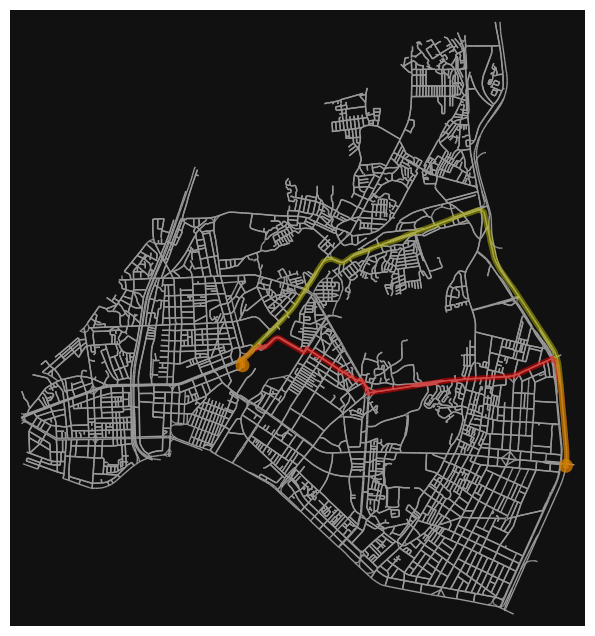

In [86]:
# 시각화
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [65]:
# 두 경로 비교

# route1의 길이 계산 (거리 기준 최적 경로의 총 길이, 단위: 미터)
route1_length = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["length"]))

# route2의 길이 계산 (시간 기준 최적 경로의 총 길이, 단위: 미터)
route2_length = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["length"]))

# route1의 소요 시간 계산 (거리 기준 최적 경로의 총 소요 시간, 단위: 초)
route1_time = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["travel_time"]))

# route2의 소요 시간 계산 (시간 기준 최적 경로의 총 소요 시간, 단위: 초)
route2_time = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["travel_time"]))

# 두 경로의 길이와 소요 시간을 출력
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 4065 meters and takes 359 seconds.
Route 2 is 5104 meters and takes 320 seconds.


#### [3] 특정 노드에서 지정한 거리/시간에 도달할 수 있는 노드 분석( 버퍼 )

OSMnx 패키지를 사용하면 도로 네트워크에서 특정 시작점으로부터 일정 거리 또는 시간 내에 도달할 수 있는 영역을 식별하는 데도 활용할 수 있다. 이러한 방법은 주로, 어떤 시설이 주변에 얼마나 영향을 미치는지 분석하거나 접근성을 분석하는데 주로 쓰인다.  
아래 코드는 도로 네트워크에서 특정 노드를 중심으로 1000m 반경 내의 서브그래프를 추출하고 시각화하는 예제이다.

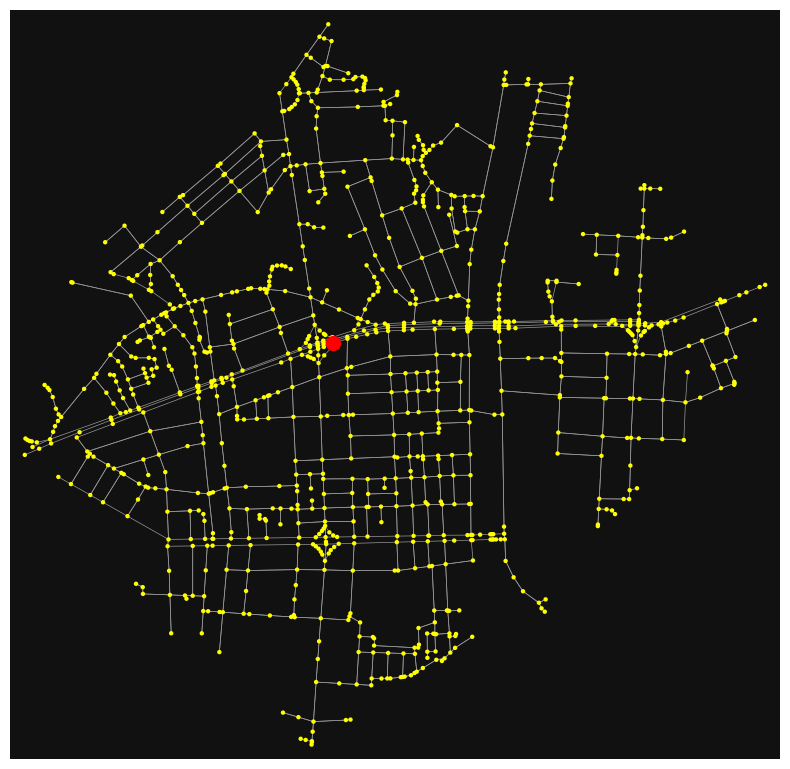

In [73]:
# 도로 네트워크 불러오기
# G = ox.graph_from_place('Gangnam, Seoul, South Korea', network_type='drive')

# 특정 노드를 선택 (예: 첫 번째 노드를 선택)
center_node = list(G.nodes)[20]

# 특정 노드를 중심으로 반경 1000m 내의 서브그래프를 ego_graph로 추출
radius = 1000  # 반경 (미터 단위)
ego_G = nx.ego_graph(G, center_node, radius=radius, distance='length')

# 서브그래프를 시각화
fig, ax = ox.plot_graph(ego_G, node_color='yellow', node_size=10, edge_linewidth=0.5, show=False)

# 중심 노드의 좌표 얻기
center_node_coords = (G.nodes[center_node]['y'], G.nodes[center_node]['x'])

# 중심 노드를 붉은색으로 표시
ax.scatter(center_node_coords[1], center_node_coords[0], c='red', s=100, zorder=5)

plt.tight_layout()
plt.show()

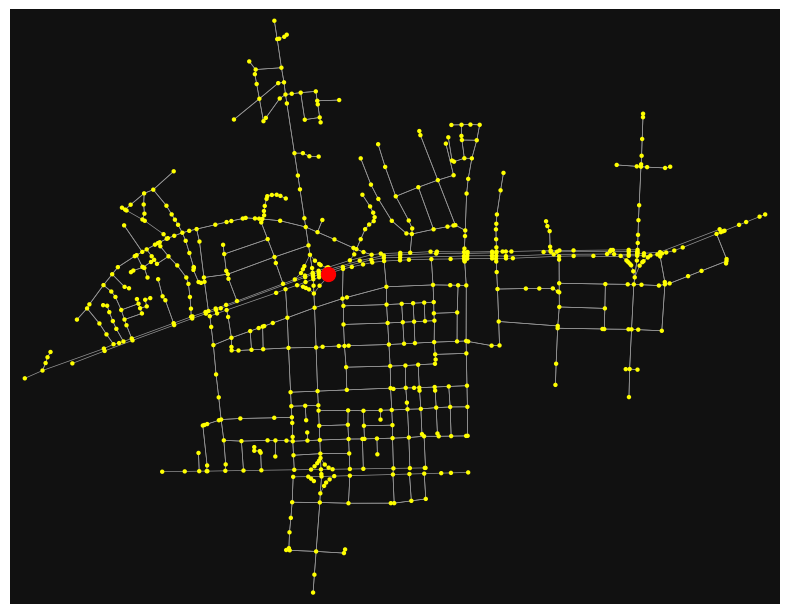

In [89]:
# 도로 네트워크 불러오기
# G = ox.graph_from_place('Gangnam, Seoul, South Korea', network_type='drive')

# 특정 노드를 선택 (예: 첫 번째 노드를 선택)
center_node = list(G.nodes)[20]

# 특정 노드를 중심으로 반경 1000m 내의 서브그래프를 ego_graph로 추출
radius = 60  # 시간 (초)
ego_G = nx.ego_graph(G, center_node, radius=radius, distance='travel_time')

# 서브그래프를 시각화
fig, ax = ox.plot_graph(ego_G, node_color='yellow', node_size=10, edge_linewidth=0.5, show=False)

# 중심 노드의 좌표 얻기
center_node_coords = (G.nodes[center_node]['y'], G.nodes[center_node]['x'])

# 중심 노드를 붉은색으로 표시
ax.scatter(center_node_coords[1], center_node_coords[0], c='red', s=100, zorder=5)

plt.tight_layout()
plt.show()

### 2.4.3 Graph 간소화
그래프 간소화는 복잡한 네트워크 데이터를 보다 효율적으로 처리하고 분석하기 위해 필요하다. 복잡한 도로망이나 경로 데이터를 단순화함으로써 계산 시간을 줄이고, 시각화나 경로 탐색 등의 작업을 용이하게 할 수 있다. 우리가 계속 사용해왔던 `graph_from_place` 함수는 기본적으로 `simplify=True` 인자를 사용하고 있다. 이는 OpenStreetMap에서 가져온 원시 그래프 데이터를 자동으로 간소화하여 반환한다는 의미이다.

`simplify_graph` 함수는 불필요한 노드와 엣지를 제거하여 그래프를 단순화한다. 교차로나 말단 노드가 아닌 중간 노드들을 합침으로써 도로를 직선화하고, 그래프의 복잡성을 줄인다. 이를 통해 네트워크 분석의 효율성을 높일 수 있다.

`consolidate_intersections` 함수는 일정 거리 이내에 있는 교차로 노드들을 하나로 통합한다. 이는 현실 세계에서 매우 근접해 있는 교차로를 단일 지점으로 처리하여 분석의 정확성을 높이고, 그래프의 구조를 더욱 간소화한다. 하지만 해당 방법은 굉장히 극단적인 방법일 수 있다. 교차로를 합친다는 것은 도로 구조의 큰 변화를 야기하므로 사용에 주의할 필요가 있다. 분석하는 공간범위가 매우 커, `simplify_graph`만으로는 분석이 어려운 경우 사용을 검토해볼 수 있겠다. 

상세한 설명은 https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.simplification.simplify_graph 을 참고

#### [1] OSMnx에서 제공하는 그래프를 간소화 하는 두가지 함수

In [90]:
# Create the raw graph
G_raw = ox.graph_from_place('성남시, 대한민국', network_type='drive', simplify=False)

In [91]:
# Simplify the graph
G_simple = ox.simplify_graph(G_raw)

# Consolidate intersections
G_consolidated = ox.consolidate_intersections(G_simple, rebuild_graph=True, tolerance=0.00057, dead_ends=False) # 약 50m

c:\Users\jiho\miniconda3\Lib\site-packages\osmnx\simplification.py:513: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = convert.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
c:\Users\jiho\miniconda3\Lib\site-packages\osmnx\simplification.py:560: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid


In [92]:
print(G_raw)
print(G_simple)
print(G_consolidated)

MultiDiGraph with 27316 nodes and 50546 edges
MultiDiGraph with 4966 nodes and 13307 edges
MultiDiGraph with 714 nodes and 2440 edges


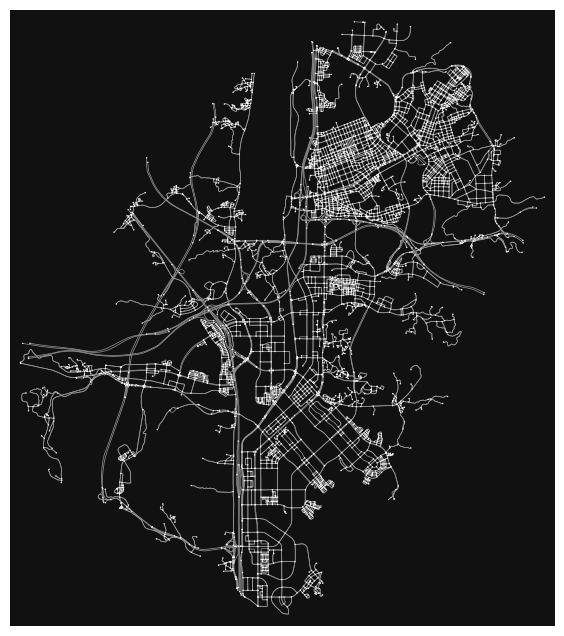

In [93]:
# consolidated 그래프 시각화
fig, ax = ox.plot_graph(
                            G_simple, 
                            figsize=(8, 8),
                            node_size=1, 
                            edge_linewidth=0.5
                        )

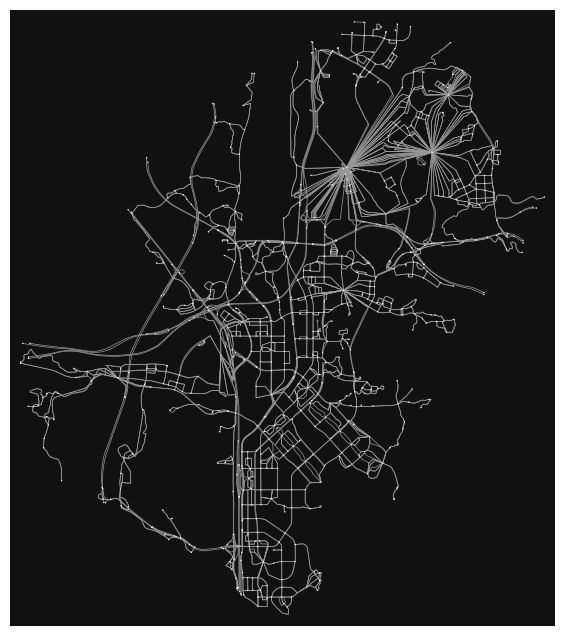

In [94]:
# consolidated 그래프 시각화
fig, ax = ox.plot_graph(
                            G_consolidated, 
                            figsize=(8, 8),
                            node_size=1, 
                            edge_linewidth=0.5
                        )

#### [2] `simplify_graph` 자세히 살펴보기

c:\Users\jiho\miniconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


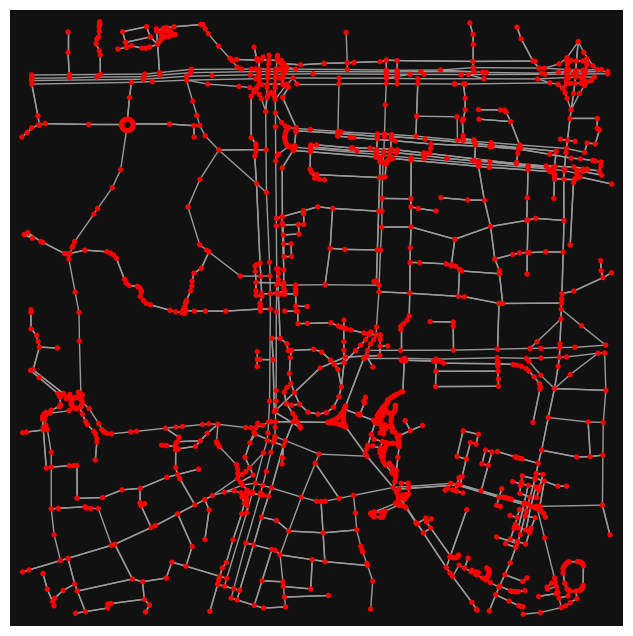

In [95]:
# 중심 위치 지점(위도, 경도) 정의 ( 서울 시청 )
location_point = (37.5665, 126.9780)

# 중심 위치로부터 500미터 거리 내에서 도로 네트워크 생성
# simplify=False로 설정하여 네트워크를 아직 단순화하지 않음
G = ox.graph_from_point(location_point, dist=500, simplify=False)

# 단순화되지 않은 네트워크 그래프를 플로팅. 노드는 빨간색(r)으로 표시됨
fig, ax = ox.plot_graph(G, node_color="r")

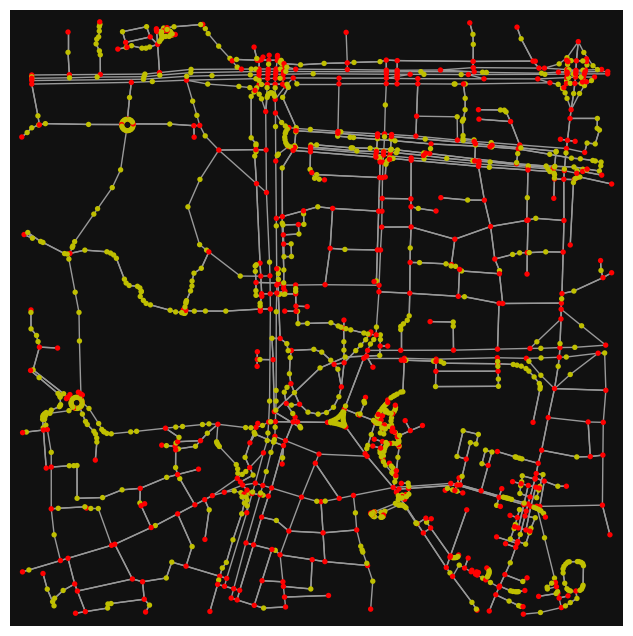

In [96]:
# 네트워크가 단순화될 때 제거될 노드를 강조
# 끝점인 노드는 빨간색(r)으로 남고, 끝점이 아닌 노드는 노란색(y)으로 표시됨
nc = ["r" if ox.simplification._is_endpoint(G, node, None) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

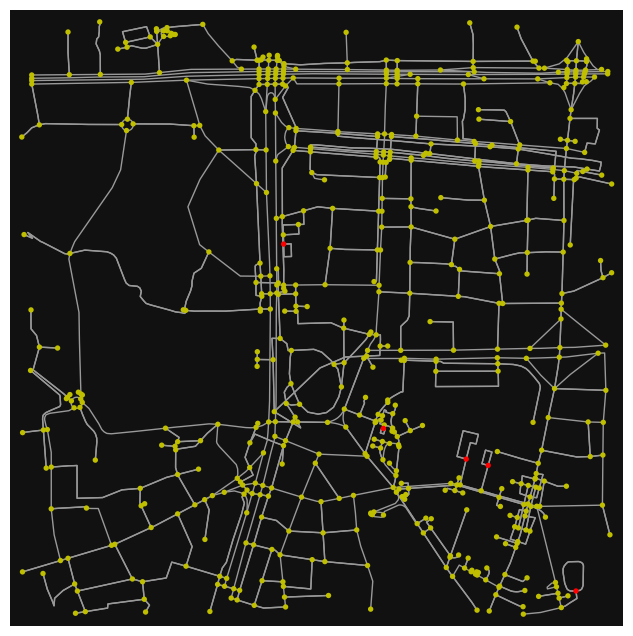

In [97]:
# 네트워크를 단순화하여 불필요한 중간 노드를 병합
# 위의 노란색 점 제거
G2 = ox.simplify_graph(G)

# 단순화된 그래프에서 자기 루프(self-loop) 엣지와 연결된 노드를 강조
# 자기 루프 엣지는 노드가 자기 자신과 연결되는 엣지임. 이런 노드는 빨간색(r)으로,
# 나머지 노드는 노란색(y)으로 표시됨
loops = [edge[0] for edge in nx.selfloop_edges(G2)]
nc = ["r" if node in loops else "y" for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc)

## 2.5 GTFS (General Transit Feed Specification)

- 대중교통 네트워크 분석을 위한 데이터
- 향후 업데이트 예정

## 2.6 Exercise

GPT와 같은 AI 툴을 적극 활용해 문제를 풀어봅시다. 다만, 출력된 코드를 보고 이해하고, 코드가 실행되지 않는다면 어디서 실행되지 않는지 파악하고 올바르게 수정할 수 있어야 합니다.

#### [1] 도로네트워크 분석

> 2.4 Section에서 실습한 OSM 데이터를 분석하는 코드를 참고하면서 아래 문제를 풀어보자.

1. 가천대학교 AI공학관에서 가천대역까지 가는 최단경로를 뽑아보고 지도상에 시각화 해봅시다. 해당 위치의 좌표는 어떻게 알 수 있을까요? ([구글지도](https://www.google.com/maps)를 사용해봅시다)
2. 가천대역을 중심으로 하여 도보로 15분 내에 도달 가능한 지역을 지도상에 나타내봅시다. 사람의 통행속도는 5km/h로 가정합니다. 